In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [3]:
#WATER

def manabe_rh(rhs, p):
#    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    rh = rhs*(p/p[0]-0.02)/(1-0.02)
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr_fixed_strato(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def rh_to_vmr(rh,T,p,itop):
    mixing_ratio = np.ones_like(T)
    vmr_itop = konrad.physics.relative_humidity2vmr(rh[itop],p[itop],T[itop])
    mixing_ratio[:itop] = konrad.physics.relative_humidity2vmr(rh[:itop],p[:itop],T[:itop])
    mixing_ratio[itop:] = vmr_itop
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

def column_water_mass(vmr,ph): #kg m-2
    mmr = vmr_to_mmr(vmr) #kg kg-1
    dp = np.diff(ph)
    M_water = np.sum(-dp*mmr/g)
    
    return M_water
    
def opt_column_water_to_rh(M_water,T_atm,p,ph,itop):
    
    def fun(rhs):
        rh = manabe_rh(rhs, p)
        vmr = rh_to_vmr(rh,T_atm,p,itop)
        rh_w_mass = column_water_mass(vmr,ph)
        res = rh_w_mass - M_water
        return res
    
    rhs_opt = optimize.brentq(fun, 0., 2)
    rh_opt = manabe_rh(rhs_opt, p)
    return rh_opt

In [4]:
#AIR

def convective_top(T_con,T_rad):
    itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][0]
    if itop == 0:
        itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][1]
    
    return itop

def coldpoint(T):
    itop = np.where(np.diff(atmosphere['T'][0])>=0)[0][0]
    
    return itop

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_0 = (T_bl + T_moist_ad[0])/2
    T_moist_ad = np.append(T_0,T_moist_ad)[:-1]

    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [5]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    return energy #J m-2

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    return energy #J m-2

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad, T_surface, SH): #find T after convective adjustment conserving thermal energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    thermal_energy = TE(T_rad,p) + SH
    tol = 10

    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist - thermal_energy
        return res
    
    Tc = T_rad[0]
    Th = T_surface
    
    dpos = fun(Th)
    dneg = fun(Tc)
    
    if dneg > 0:
#        print('Trad high already', dneg)
        ds = dneg
        dneg = 0
        Ts = Tc
    
    if dpos < 0:
#        print('Tsurf low already', dpos)
        ds = dpos
        dpos = 0
        Ts = Th
        
    Ts = Tc + (Th-Tc) * -dneg/(-dneg+dpos)
    ds = fun(Ts)
#    print(ds)

    if ds > 0:
        dpos = ds
        Th = Ts
    else:
        dneg = ds
        Tc = Ts
    
    maxiter = 100
    k = 0
    while dpos>tol and np.abs(dneg)>tol and k < maxiter:
        Ts = Tc + (Th-Tc) * -dneg/(-dneg+dpos)
        ds = fun(Ts)
    #    print(ds)
        
        if ds > 0:
            dpos = ds
            Th = Ts
        else:
            dneg = ds
            Tc = Ts
        k += 1
        
    if k == 100:
        print(dpos, dneg, ds, Th, Tc, Ts, T_rad[0])
        print('reached max iter')
    T_bl = Ts
    T_con = moist_adiabat(p,T_bl,T_rad)

    return T_con, ds


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p) + SH
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [6]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

In [7]:
%%time
#### PRECIPITATION TEST
heat_sink = 0.
opacity = 66.

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50)
radiation = konrad.radiation.RRTMG(solar_constant=551.58-opacity)
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev'])
print(M_w)

ndays = 15000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

Bowen = 0.1
prec_eff = 1/(1+Bowen)
print(prec_eff)

printcounter = 0
status = 0

#### RCE FOR PRESENT-DAY CO2
atmosphere['CO2'][0] = 348/1e6
for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    troposphere_radiation = np.sum(rad_heat_atm[:conv_top])
    atm_rad = np.sum(rad_heat_atm[:])
     
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:] = ((rad_heat_atm[:])
                                 /cp_air * g/-np.diff(atmosphere['phlev'])[:] * seconds_day)

    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    #temperature of atmosphere after radiative update

    atmosphere['T'] += heating_rates * timestep
    T_radiation = atmosphere['T'][0].copy()
    
#    print('pre rad',surface['temperature'])
        #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    old_T_bl = np.sum(T_radiation[:n_bl])/n_bl
    
    #    print('post rad',surface['temperature'])
    LH = latent_heat(vmr_bl, old_T_bl,atmosphere['phlev'][0])
    SH = sensible_heat(old_T_bl,surface['temperature'].copy(),atmosphere['phlev'][0])
#    print(SH,LH)
    
    prec_eff = np.minimum(1.,LH/(LH+SH))
#    print(prec_eff)
    
    status += 1
    if printcounter == 200:
        print(status/2)
        printcounter = 0
    
    printcounter += 1
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    surface['temperature'] += ((- SH - LH) 
                               * seconds_day * timestep / surface.heat_capacity)
    
    prec_heating = prec_eff * troposphere_radiation #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv * seconds_day * timestep
    
    atmosphere['T'][0], E_dif = T_convection_TE(atmosphere['plev'], T_radiation, surface['temperature'],
                                         (SH - prec_heating - heat_sink) * seconds_day * timestep)

    prec_mass -= E_dif/Lv

    
    #water adjustment
    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    cold_point = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + prec_mass + LH/Lv *seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],cold_point)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],cold_point)
    
    
### Record RCE 1xCO2
dE_1 = E_dif.copy()/(timestep*seconds_day)
RH_1 = RH.copy()
Mw_1 = M_w.copy()
vmr_1 = atmosphere['H2O'][0].copy()
T_atm_1 = atmosphere['T'][0].copy()
SH_1 = SH.copy()
LH_1 = LH.copy()
Prec_1 = prec_mass.copy()/timestep
atm_rad_1 = atm_rad.copy()
sfc_rad_1 = net_rad_surface.copy()
T_sfc_1 = surface['temperature'].copy()

OLR_2 = np.zeros((nsteps))
T_sfc_2 = np.zeros((nsteps))
toa_2 = np.zeros((nsteps))


#### RCE FOR DOUBLE CO2
atmosphere['CO2'][0] *= 2
for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    troposphere_radiation = np.sum(rad_heat_atm[:conv_top])
    atm_rad = np.sum(rad_heat_atm[:])
     
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:] = ((rad_heat_atm[:])
                                 /cp_air * g/-np.diff(atmosphere['phlev'])[:] * seconds_day)

    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    #temperature of atmosphere after radiative update

    atmosphere['T'] += heating_rates * timestep
    T_radiation = atmosphere['T'][0].copy()
    
#    print('pre rad',surface['temperature'])
        #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    old_T_bl = np.sum(T_radiation[:n_bl])/n_bl
    
    #    print('post rad',surface['temperature'])
    LH = latent_heat(vmr_bl, old_T_bl,atmosphere['phlev'][0])
    SH = sensible_heat(old_T_bl,surface['temperature'].copy(),atmosphere['phlev'][0])
#    print(SH,LH)
    
    prec_eff = np.minimum(1.,LH/(LH+SH))
#    print(prec_eff)
    
    status += 1
    if printcounter == 200:
        print(status/2)
        printcounter = 0
    
    printcounter += 1
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    surface['temperature'] += ((- SH - LH) 
                               * seconds_day * timestep / surface.heat_capacity)
    
    prec_heating = prec_eff * troposphere_radiation #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv * seconds_day * timestep
    
    atmosphere['T'][0], E_dif = T_convection_TE(atmosphere['plev'], T_radiation, surface['temperature'],
                                         (SH - prec_heating - heat_sink) * seconds_day * timestep)

    prec_mass -= E_dif/Lv

    
    #water adjustment
    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    cold_point = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + prec_mass + LH/Lv *seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],cold_point)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],cold_point)
    T_sfc_2[i] = surface['temperature'].copy()
    OLR_2[i] = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
    toa_2[i] = radiation['toa'].copy()

    
### Record RCE 2xCO2
dE_2 = E_dif.copy()/(timestep*seconds_day)
RH_2 = RH.copy()
Mw_2 = M_w.copy()
vmr_2 = atmosphere['H2O'][0].copy()
T_atm_2 = atmosphere['T'][0].copy()
SH_2 = SH.copy()
LH_2 = LH.copy()
Prec_2 = prec_mass.copy()/timestep
atm_rad_2 = atm_rad.copy()
sfc_rad_2 = net_rad_surface.copy()

18.767710263973953
0.9090909090909091
100.5
200.5
[852.78795004] [-749.18424559] [-749.18424559] [288.75308262] [288.75308262] [288.75308262] 287.9187410552149
reached max iter
300.5
400.5
500.5
600.5
700.5
800.5
900.5
1000.5
1100.5
1200.5
1300.5
1400.5
1500.5
1600.5
1700.5
1800.5
1900.5
2000.5
2100.5
2200.5
2300.5
2400.5
2500.5
2600.5
2700.5
2800.5
2900.5
3000.5
3100.5
3200.5
3300.5
3400.5
3500.5
3600.5
3700.5
3800.5
3900.5
4000.5
4100.5
4200.5
4300.5
4400.5
4500.5
4600.5
4700.5
4800.5
4900.5
5000.5
5100.5
5200.5
5300.5
5400.5
5500.5
5600.5
5700.5
5800.5
5900.5
6000.5
6100.5
6200.5
6300.5
6400.5
6500.5
6600.5
6700.5
6800.5
6900.5
7000.5
7100.5
7200.5
7300.5
7400.5
7500.5
7600.5
7700.5
7800.5
7900.5
8000.5
8100.5
8200.5
8300.5
8400.5
8500.5
8600.5
8700.5
8800.5
8900.5
9000.5
9100.5
9200.5
9300.5
9400.5
9500.5
9600.5
9700.5
9800.5
9900.5
10000.5
10100.5
10200.5
10300.5
10400.5
10500.5
10600.5
10700.5
10800.5
10900.5
11000.5
11100.5
11200.5
11300.5
11400.5
11500.5
11600.5
11700.5
11800.5

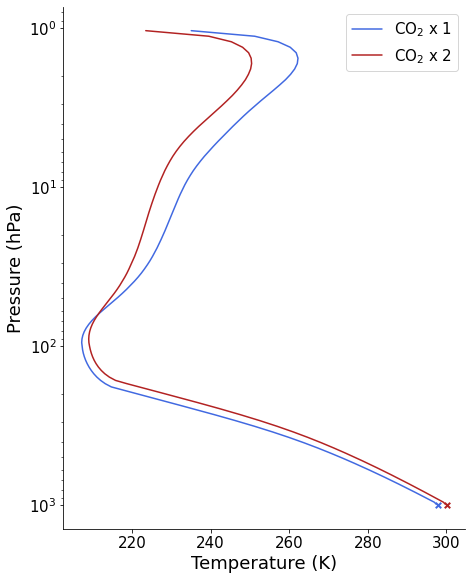

In [8]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(T_atm_1, atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_sfc_1, atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')
ax.plot(T_atm_2, atmosphere['plev']/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2')
ax.scatter(T_sfc_2[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'firebrick', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [9]:
print(Prec_1, Prec_2)
print(LH_1, LH_2)
print(SH_1,SH_2)
print(dE_1,dE_2)
print(LH_1/Lv * seconds_day, LH_2/Lv * seconds_day)
print(RH_1[0],RH_2[0])
print(T_sfc_1,T_sfc_2[-1])
print(Mw_1,Mw_2)

[-4.75899234] [-5.05558028]
137.75714648503197 146.34266587605578
[14.96091149] [14.44663501]
[-2.261441] [-2.22619933]
4.758983389167038 5.055580300556265
0.6959704709856743 0.714073260121268
[297.86780232] 300.1553194838049
[42.44279402] [52.07391256]


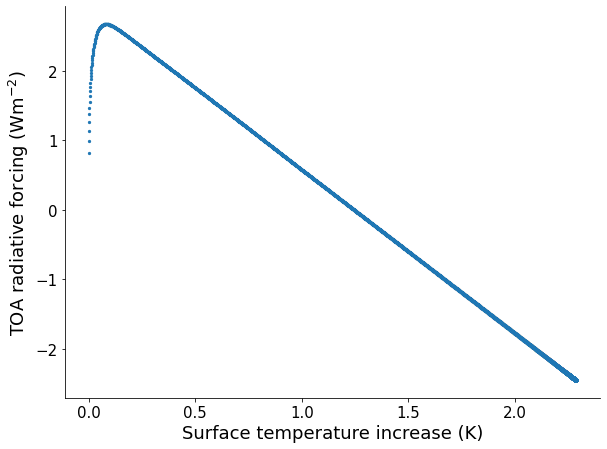

LinregressResult(slope=-2.3503637897010976, intercept=2.9296215117477575, rvalue=-0.9999991886199263, pvalue=0.0, stderr=1.7432763285779856e-05)


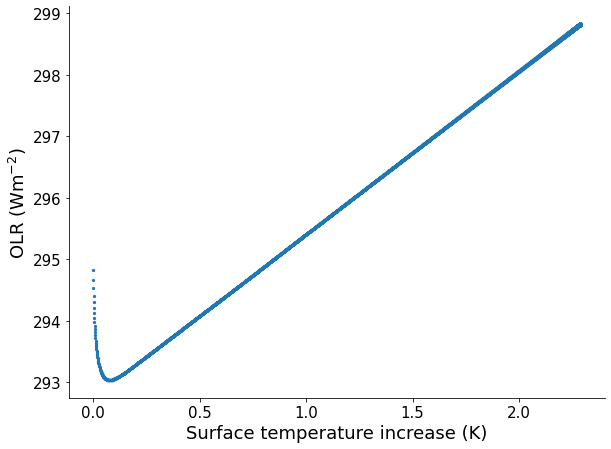

LinregressResult(slope=2.65560214962989, intercept=292.75074389098694, rvalue=0.9999995363909892, pvalue=0.0, stderr=1.488873530282605e-05)


In [10]:
from scipy.stats import linregress

T_anom = T_sfc_2 - T_sfc_1
fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))

ax.scatter(T_anom,toa_2, s=5)

ax.set_xlabel('Surface temperature increase (K)')
ax.set_ylabel('TOA radiative forcing (Wm$^{-2}$)')

plt.show()

print(linregress( T_anom[500:], toa_2[500:]))


fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))

ax.scatter(T_anom,OLR_2, s=5)

ax.set_xlabel('Surface temperature increase (K)')
ax.set_ylabel('OLR (Wm$^{-2}$)')

plt.show()
print(linregress( T_anom[500:], OLR_2[500:]))

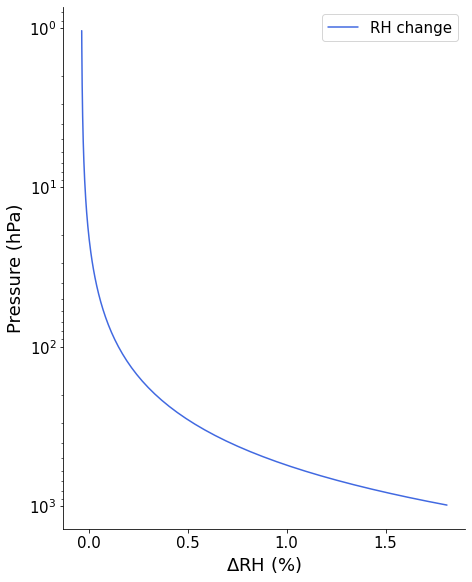

In [11]:

fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

ax.plot(100*(RH_2-RH_1), atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'RH change')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('$\\Delta$RH (%)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [12]:
print((vmr_2[0]-vmr_1[0])/vmr_1[0]*100/T_anom[-1])
print((Prec_2-Prec_1)/Prec_1*100/T_anom[-1])
print((Mw_2-Mw_1)/Mw_1*100/T_anom[-1])

7.71828226249835
[2.72442039]
[9.91992528]
